In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Import libraries

In [2]:
# Modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import plotly.io as pio

In [3]:
# Enable to render plotly graphs into GitHub
pio.renderers.default = "svg"

In [4]:
# Select country in analysis ('FIN', 'DEN', 'NOR', 'SWE')
dep_var = 'DEN'

# Dependant variable select Orders or TIV
target = 'TIV'

### Load Data

In [5]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + 'target.xlsx'   
data = pd.read_excel(file, sheet_name=target)

# Set index
data = data.set_index("Date").asfreq('MS')

In [6]:
data.tail(37)

,FIN,DEN,NOR,SWE
Date,,,,
2019-12-01,90.590798,89.837989,81.970365,160.356089
2020-01-01,119.107876,108.472214,71.561105,58.983455
2020-02-01,91.208337,87.433947,77.519980,74.563178
2020-03-01,101.452871,88.363045,91.014476,94.608932
2020-04-01,65.955394,59.723593,56.994966,65.750472
2020-05-01,56.383536,67.046048,67.547567,56.029309
2020-06-01,88.506603,104.802276,90.441114,86.396340
2020-07-01,100.394233,110.922711,80.018202,78.923113
2020-08-01,93.601301,102.642123,85.676744,88.011008


In [7]:
# Create copies of the original dataframe
df_diff = data.copy()

In [8]:
# Apply first difference to stationarize and detrend
df_diff[dep_var + '_diff'] = df_diff[dep_var].diff(1)
df_diff.drop([dep_var], axis=1, inplace=True)
df_diff = df_diff.rename(columns={dep_var + '_diff': dep_var})    
df_diff.dropna(inplace=True)

In [9]:
df_diff

,FIN,NOR,SWE,DEN
Date,,,,
2006-02-01,128.084250,64.653451,67.391665,-3.716393
2006-03-01,151.605878,84.919086,92.858327,21.555078
2006-04-01,135.086704,73.288018,95.325089,-5.806864
2006-05-01,166.978193,90.939393,107.940718,14.255850
2006-06-01,166.492984,85.922471,104.976625,7.316648
...,...,...,...,...
2022-08-01,78.449535,94.243053,71.260900,16.892167
2022-09-01,74.997932,109.443986,76.413249,1.323965
2022-10-01,68.348358,94.714030,76.986837,-12.554439


In [10]:
# Get only the target variable
df = df_diff[[dep_var]]

In [11]:
df

,DEN
Date,
2006-02-01,-3.716393
2006-03-01,21.555078
2006-04-01,-5.806864
2006-05-01,14.255850
2006-06-01,7.316648
...,...
2022-08-01,16.892167
2022-09-01,1.323965
2022-10-01,-12.554439


In [12]:
# Function to revert back differences (TO REVIEW)
def diff_inv(series_diff, first_value):
    # Cumsum serie starting from first value
    series_inverted = np.r_[first_value,series_diff].cumsum()
    # Delete first element 
    new_array = np.delete(series_inverted, [0])   
    return new_array

### Split Data

In [13]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

print('\nData shape:', train.shape, test.shape)

# Save previous value to inverse transform
previous_value = data.iloc[-steps-1][dep_var]
#df_original = df_original.iloc[1:]


Dataset length : (n=203)
Train dates    : 2006-02-01 00:00:00 --- 2019-12-01 00:00:00  (n=167)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)

Data shape: (167, 1) (36, 1)


In [14]:
previous_value

89.8379885024098

### Scoring function

In [15]:
metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy
        
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
                
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_true, mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions in " + dep_var)    

        fig.show()         

### Models

XGBoost Model Performance:
Mean Absolute Error: 25.57.
Mean Squared Error: 1163.45.
Root Mean Squared Error: 34.11.
R^2 Score = -0.57.
Mean Absolute Percentage Error: 348.36%.
Accuracy = -248.36%.


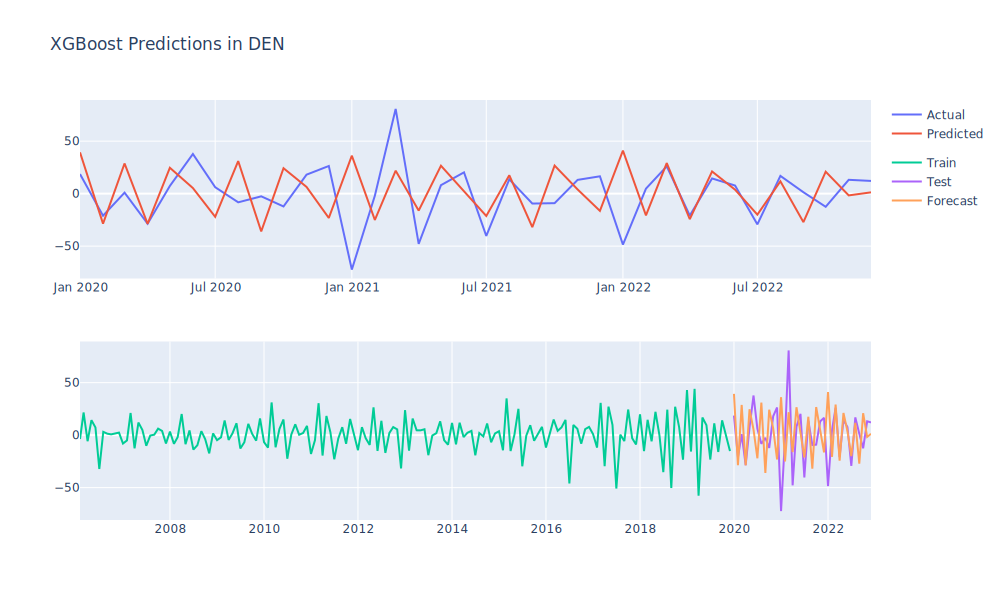

Gradient Boosting Model Performance:
Mean Absolute Error: 21.84.
Mean Squared Error: 829.67.
Root Mean Squared Error: 28.80.
R^2 Score = -0.12.
Mean Absolute Percentage Error: 209.51%.
Accuracy = -109.51%.


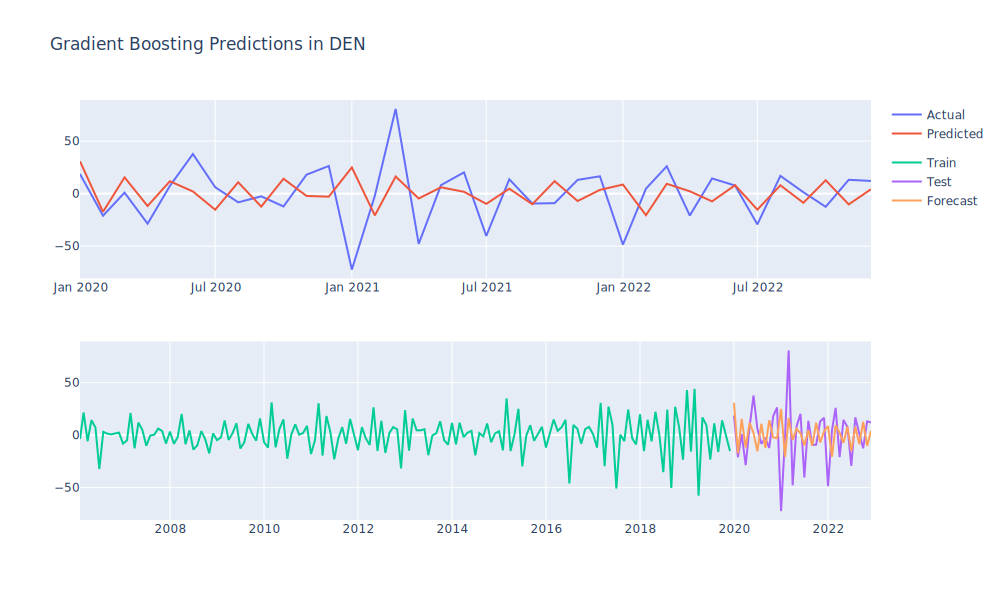

LightGBM Model Performance:
Mean Absolute Error: 24.25.
Mean Squared Error: 1009.37.
Root Mean Squared Error: 31.77.
R^2 Score = -0.36.
Mean Absolute Percentage Error: 313.65%.
Accuracy = -213.65%.


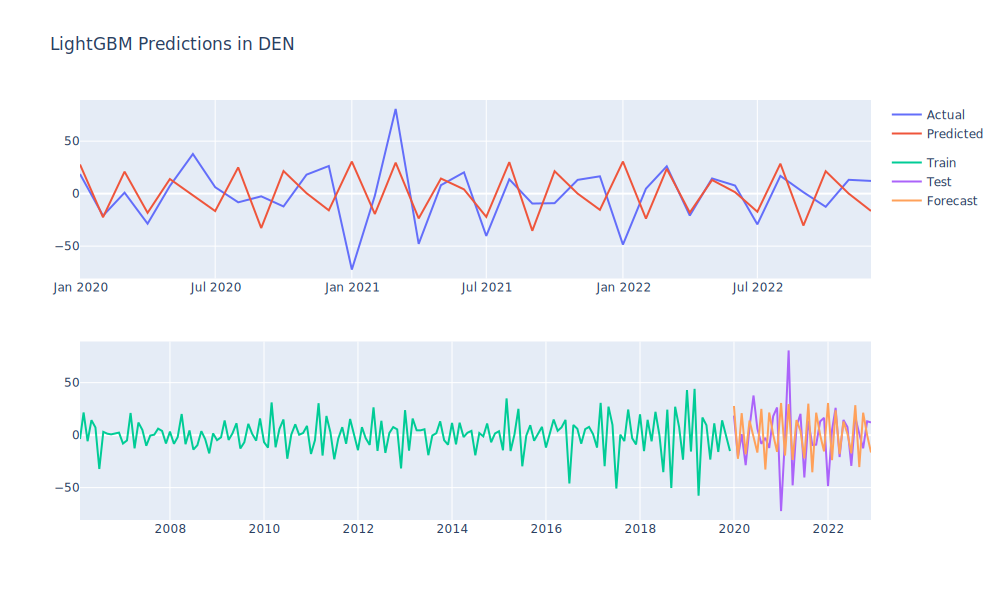

In [16]:
modelclasses = [
#    ["Extra Tree", ExtraTreesRegressor],
    ["XGBoost", XGBRegressor],
    ["Gradient Boosting", GradientBoostingRegressor],
#    ["Random Forest", RandomForestRegressor],
#    ["Ada Boost", AdaBoostRegressor],
    ["LightGBM", LGBMRegressor],
#    ["Decision Tree", DecisionTreeRegressor]
]

number_of_lags = 12

for model_name, Model in modelclasses:            
        
    # Create forecaster
    forecaster = ForecasterAutoreg(
            regressor = Model(),
            lags = number_of_lags
    )
    
    # Fit model
    forecaster.fit(y=train[dep_var])

    # Extract training matrix (for exploration only)
    X, y = forecaster.create_train_X_y(train[dep_var])    
        
    # Predict
    preds = forecaster.predict(steps=steps)
                
    # Score
    scoring(model_name, test[dep_var], preds, True, True)

In [17]:
test[dep_var] - preds

Date
2020-01-01     -9.134867
2020-02-01      1.489038
2020-03-01    -20.009568
2020-04-01    -10.346041
2020-05-01     -6.575381
2020-06-01     39.577150
2020-07-01     22.743882
2020-08-01    -33.269743
2020-09-01     30.221306
2020-10-01    -33.752215
2020-11-01     17.664471
2020-12-01     42.247910
2021-01-01   -102.924027
2021-02-01     17.460924
2021-03-01     51.168581
2021-04-01    -24.225942
2021-05-01     -6.312526
2021-06-01     16.196583
2021-07-01    -18.154464
2021-08-01    -16.339017
2021-09-01     25.925483
2021-10-01    -30.458394
2021-11-01     13.067778
2021-12-01     31.964163
2022-01-01    -79.139113
2022-02-01     28.556105
2022-03-01      2.329309
2022-04-01     -2.847501
2022-05-01      1.506615
2022-06-01      6.310953
2022-07-01    -12.026063
2022-08-01    -11.637511
2022-09-01     31.756867
2022-10-01    -33.930898
2022-11-01     13.131653
2022-12-01     28.640965
Freq: MS, dtype: float64

In [18]:
data.iloc[-1][dep_var]

88.5024098484408

In [19]:
data.index.min()

Timestamp('2006-01-01 00:00:00', freq='MS')

In [20]:
# Create a series with the dates that were dropped with differencing
first_train_value = pd.Series(data.iloc[-1][dep_var], index = [data.index.min()])
last_train_value = data[dep_var][:-steps-1]

In [21]:
first_train_value

2006-01-01    88.50241
dtype: float64

In [22]:
rebuilt = first_train_value.append(last_train_value).append(preds)

C:\Users\ne74255\AppData\Local\Temp/ipykernel_2536/2470026989.py:1: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ne74255\AppData\Local\Temp/ipykernel_2536/2470026989.py:1: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [23]:
#revert differencing:
rebuilt = rebuilt.cumsum()

In [24]:
rebuilt

2006-01-01       88.502410
2006-01-01      154.143197
2006-02-01      216.067592
2006-03-01      299.547065
2006-04-01      377.219674
                  ...     
2022-08-01    14790.997250
2022-09-01    14760.564347
2022-10-01    14781.940806
2022-11-01    14781.967506
2022-12-01    14765.428045
Length: 204, dtype: float64

In [25]:
# Check how far were the predictions from the actual values
rebuilt[-steps:] - test[dep_var][-steps:]

2020-01-01    14746.774957
2020-02-01    14763.920145
2020-03-01    14762.891446
2020-04-01    14774.166585
2020-05-01    14752.102514
2020-06-01    14719.847819
2020-07-01    14734.860165
2020-08-01    14774.250342
2020-09-01    14735.748448
2020-10-01    14766.916609
2020-11-01    14737.028690
2020-12-01    14712.851740
2021-01-01    14842.109893
2021-02-01    14752.289641
2021-03-01    14699.169954
2021-04-01    14804.088074
2021-05-01    14762.540429
2021-06-01    14754.409580
2021-07-01    14792.818385
2021-08-01    14768.846154
2021-09-01    14756.566801
2021-10-01    14777.554200
2021-11-01    14755.404487
2021-12-01    14736.534802
2022-01-01    14832.177021
2022-02-01    14755.046501
2022-03-01    14757.449785
2022-04-01    14786.317843
2022-05-01    14763.900712
2022-06-01    14772.054656
2022-07-01    14791.763200
2022-08-01    14774.105083
2022-09-01    14759.240382
2022-10-01    14794.495246
2022-11-01    14768.809153
2022-12-01    14753.326541
dtype: float64

In [42]:
# Explore training matrix
X


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,
2007-02-01,-8.025086,2.404042,1.254283,0.720051,1.376227,3.129900,-32.257128,7.316648,14.255850,-5.806864,21.555078,-3.716393
2007-03-01,-5.075199,-8.025086,2.404042,1.254283,0.720051,1.376227,3.129900,-32.257128,7.316648,14.255850,-5.806864,21.555078
2007-04-01,21.096336,-5.075199,-8.025086,2.404042,1.254283,0.720051,1.376227,3.129900,-32.257128,7.316648,14.255850,-5.806864
2007-05-01,-12.595087,21.096336,-5.075199,-8.025086,2.404042,1.254283,0.720051,1.376227,3.129900,-32.257128,7.316648,14.255850
2007-06-01,12.008594,-12.595087,21.096336,-5.075199,-8.025086,2.404042,1.254283,0.720051,1.376227,3.129900,-32.257128,7.316648
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-23.250682,9.494222,16.787643,-57.685384,44.079902,-15.643691,42.918530,-23.395854,7.473434,27.036757,-50.397770,24.290111
2019-09-01,11.236281,-23.250682,9.494222,16.787643,-57.685384,44.079902,-15.643691,42.918530,-23.395854,7.473434,27.036757,-50.397770
2019-10-01,-16.044364,11.236281,-23.250682,9.494222,16.787643,-57.685384,44.079902,-15.643691,42.918530,-23.395854,7.473434,27.036757


### LigthGBM

### Summary

In [43]:
metrics

,XGBoost,Gradient Boosting,LightGBM
Mean Absolute Error,25.566398,20.657412,24.251195
Mean Squared Error,1163.446272,775.691700,1009.371799
Root Mean Squared Error,34.109328,27.851242,31.770612
R^2,-0.568505,-0.045752,-0.360789
Mean Absolute Percentage Error,348.361985,202.226570,313.646073
Accuracy,-248.361985,-102.226570,-213.646073


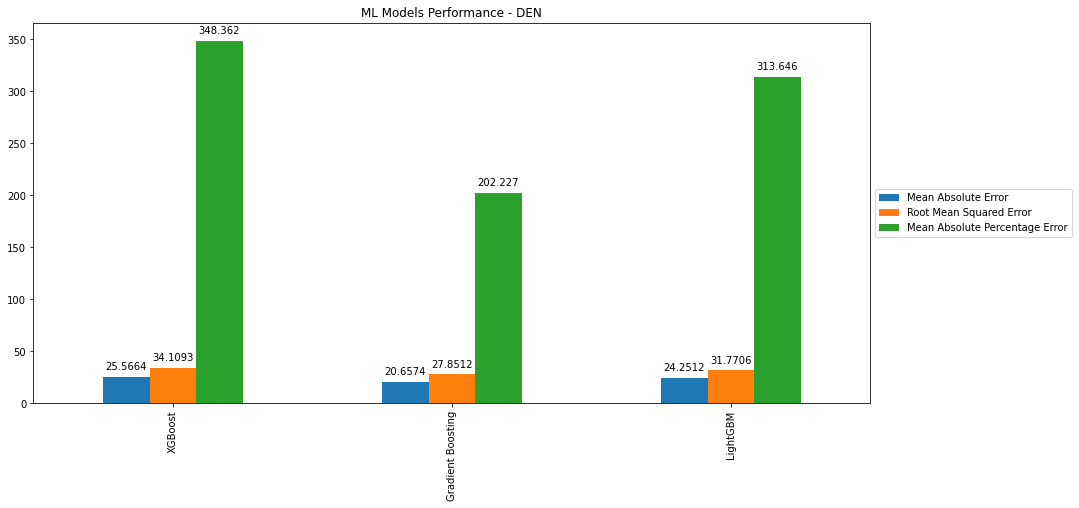

In [44]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance - " + dep_var, figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))